In questo notebook vediamo come scomporre il calcolo di tanh nei singoli componenti ne costituiscono la formula (vedi sotto). L'obiettivo è dimostrare che il calcolo dell'espressione può essere implementato a diversi livelli di profondità e il risultato è sempre lo stesso
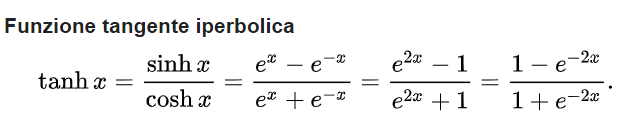

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from graphviz import Digraph

# Helper function che serve per ottenere tutti gli edge e i node presenti nel graph partendo dal nodo di root
def trace(root):
    
    # inizializza i set vuoti
    nodes, edges = set(), set()
    
    # Funzione ricorsiva che, dato un nodo, ne estre i children e li aggiunge ai set di Edge e Node
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    # Chiamata iniziale alla funzione ricorsiva
    build(root)
    return nodes, edges

# Funzione che richiama l'API di Graphviz per disegnare il grafo con i nodi e gli edge che compongono la funzione
#
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    
    # Chiamo Helper Function per estrarre gli edge e i node
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
#        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
#        dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Riprendiamo quindi la classe Value e modifichiamola per gestire una serie aggiuntiva di operazioni:
- somma di un Value con una costante
- il prodotto di un Value con una costante
- il prodotto di una costante con un Value (utilizzando __rmul__())
- exponentiation
- divisione
- sottrazione
- elevazione a potenza

In [3]:
class Value:
    
    # Costruttore
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        
        self.grad = 0.0
        self._backward = lambda: None   # Funzione che non fa nulla
        self._prev = set(_children) 
        self._op = _op
        self.label = label
        
    # Metodo utilizzato da Python per la visualizzazione dell'oggetto. Consente di impostare un visualizzazione user friendly
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Definisce l'operatore per la somma (+). Quando trova l'operatore +, Python chiama questo metodo
    def __add__(self, other):
        
        # Per gestire la somma di un Value con una costante
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata dei 2 termini rispetto all'output.
        # Dal momento che la local derivative per una somma è = 1, moltiplico 1 * la derivata del risultato della somma
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    # Metodo x negazione (-Value()). Utilizzato dal metodo successivo x sottrazione
    def __neg__(self):
        return self * -1
    
    # Definisce l'operatore sottrazione
    def __sub__(self, other):
        return self + (-other)
    
    
    # Definisce l'operatore per la prodottp (*). Quando trova l'operatore *, Python chiama questo metodo
    def __mul__(self, other):
        
         # Per gestire la somma di un Value con una costante
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata dei 2 fattori del prodotto
        # rispetto all'output.
        # Dal momento che la local derivative per un prodotto è = al valore dell'altro fattore,
        # moltiplico l'altro fattore * la derivata del prodotto
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    # Questo metodo viene richiamato da Python in caso di 2 * Value(). Restituirebbe un errore e quindi Python
    # richiama questo metodo per dare l'opportunità di gestire l'errore invertendo l'ordine degli operatori
    def __rmul__(self,other):
        return self * other
    
    # Questo metodo viene richiamato dabPython per l'elevazione a potenza (**n). Viene utilizzato per implementare la divisione
    # in quanto a / b corrisponde a a * (1/b) e quindi a * (b**-1)
    #
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data**other, (self,), f'**{other}')
        
        # Sappiamo che la derivata di una potenza è uguale a n x**(n-1)
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    
    # Metodo per la divisione: utilizza la moltiplicazione del valore del dividendo 
    # per il divisone elevato a potenza -1. Quindi utilizza il metodo precedente
    #
    def __truediv__(self,other):
        return self * other**-1
    
    # Metodo per il calcolo della funzione tanh. 
    # E' possibile utilizzare la funzione "composta" invece che le singole operazioni che la compongono in quanto 
    # siamo in grado di calcolarne la derivata
    #
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata della funzione tanh 
        # rispetto all'output.
        # Dal momento che la local derivative per tanh è = (1 - x**2), applicando la chain rule
        # moltiplico questa local derivative* la derivata del prodotto
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    # Calcolo dell'a funzione exp: costituisce una delle operazioni che fanno parte della formula di tanh
    # 
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward= _backward
        
        return out
        
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

Proviamo ad eseguire ancora (come nei notebook percedenti) forward a backward pass utilizzando l'operatore "tanh()".

In [4]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8812735870195432, label='b')

# x1*w1 +x2*w2 +b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

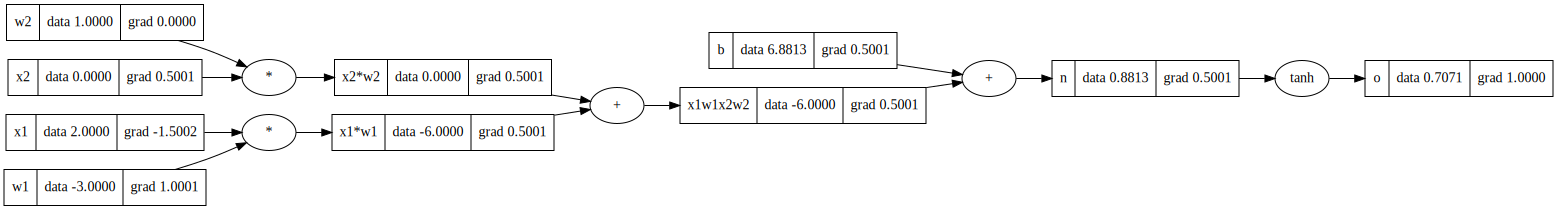

In [5]:
draw_dot(o)

Proviamo ora a sostituire tanh con le singole operazioni che ne compongono la formula (e che ora sono state implementate nella classe Value


In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8812735870195432, label='b')

# x1*w1 +x2*w2 +b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b; n.label = 'n'
#----
# o = n.tanh();
#
e = (2*n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'
o.backward()

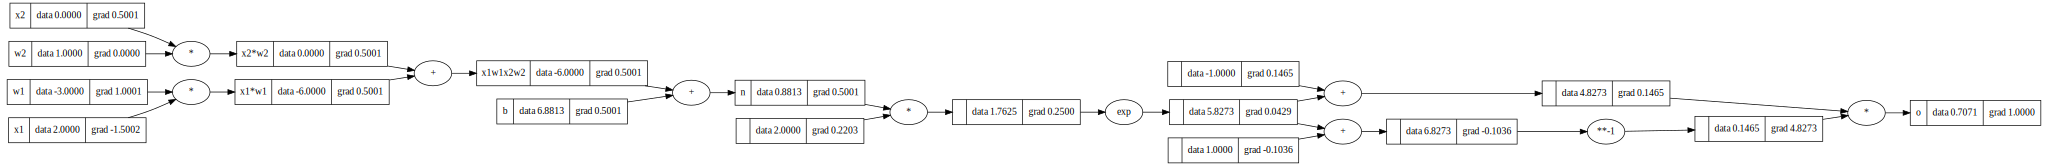

In [7]:
draw_dot(o)

Stesso risultato!!! :-)